In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns


In [2]:
# Expected Score function for elo rating

def get_exp_score_a(rating_a, rating_b):
    return 1.0 /(1 + 10**((rating_b - rating_a)/400.0))

# Elo Rating adjustment function

def rating_adj(player, exp_score, score, k=32):
    if player.matches >= 5:
        k = k * .75
    elif player.matches < 5:
        k = k * .5
    return player.rating + k * (score - exp_score)        


In [3]:
#Function defining Player class
class Player(object):
    def __init__(self, name, rating, matches):
        self.rating = rating
        self.name = name
        self.matches = matches
    #Method to convert to dictionary for mapping to dataframe later
    def to_dict(self):
        return {
            'Name': self.name,
            'Rating': self.rating,
            'Total Matches': self.matches
        }
    

In [4]:
# creates dictionary of dancers with base 1500 ELO rating

def create_bracket(file):
    df = pd.read_csv(file)
    #create set which automatically removes duplicates from 2 player columns
    player_set = set(list(df['Player_1'].astype(str)) + list(df['Player_2'].astype(str)))
    #create list that creates each Player class instance for each dancer with ELO rating of 1500
    player_list = []
    for name in list(player_set):
        player_list.append(Player(name, 1500, 0))
    return player_list
        

In [5]:
matches_file = r"/home/gam32bit/Documents/Py_Projects/Electro.fr.sum/electro2022.csv"

In [6]:
electro_bracket = create_bracket(matches_file)

In [7]:
## Function to run matches based on created bracket and tabulate upsets

def run_matches(file, bracket):
    #load spreadsheet
    match_df = pd.read_csv(file)
    match_df = match_df.reset_index()
    upset = {}
    #calculate total matches for each player
    for player in bracket:
        player.matches = sum(match_df.Player_1.str.count(player.name)) + \
        sum(match_df.Player_2.str.count(player.name))
    #iterate through spreadsheet and calculate ELO match results
    for idx, row in match_df.iterrows():
        p1 = match_df.Player_1[idx]
        p2 = match_df.Player_2[idx]
        result = match_df.Winner[idx]
        p1_stat = [x for x in bracket if x.name == p1]
        p2_stat = [x for x in bracket if x.name == p2]
        exp_score_a = get_exp_score_a(p1_stat[0].rating, p2_stat[0].rating)
        #Exception for special "Melee" battle
        if match_df.Special[idx] == "Melee":
            score = .25
        else:
            score = 1
        #Award points and add upsets to upset dictionary
        if result == p1:
            if p1_stat[0].rating < p2_stat[0].rating:
                upset[(p2_stat[0].rating - p1_stat[0].rating)] = [f'{p1}:{p1_stat[0].rating}, {p2}:{p2_stat[0].rating}']
            p1_stat[0].rating = rating_adj(p1_stat[0], exp_score_a, score)
            p2_stat[0].rating = rating_adj(p2_stat[0], 1 - exp_score_a, 0)
        elif result == p2:
            if p2_stat[0].rating < p1_stat[0].rating:
                upset[(p1_stat[0].rating - p2_stat[0].rating)] = [f'{p2}:{p2_stat[0].rating}, {p1}:{p1_stat[0].rating}']
            p1_stat[0].rating = rating_adj(p1_stat[0], exp_score_a, 0)
            p2_stat[0].rating = rating_adj(p2_stat[0], 1 - exp_score_a, score)   
    print(upset)
    return bracket
        
            

In [8]:
electro_matches = run_matches(matches_file, electro_bracket)

{4.0: ['Hflow:1508.0, Filfrap:1512.0'], 7.769751663554189: ['Hflow:1516.0920993345783, K-Neutron:1523.8618509981325'], 12.0: ['Sparrow:1488.0, Kredox:1500'], 0.1381490018675322: ['Filfrap:1499.8618509981325, Fabien:1500'], 7.815825740515265: ['Goku:1500, Treil:1507.8158257405153'], 11.463176068791654: ['Goku:1512.2699035300939, Filfrap:1523.7330795988855'], 3.585699413622933: ['Sparrow:1488.414300586377, Vision:1492.0'], 4.675258929227539: ['Kredox:1487.585699413623, Chenny:1492.2609583428505'], 8.252832609547795: ['Kredox:1499.7471673904522, Chinzou:1508.0'], 15.19325994952851: ['DS:1508.0, K-Neutron:1523.1932599495285'], 4.053179897289056: ['Gara:1523.60426499792, Filfrap:1527.657444895209'], 10.89140211116569: ['Kredox:1500.8046796617627, Gara:1511.6960817729284'], 4.819267809738449: ['Kredox:1495.1807321902616, Jade:1500'], 0.6799707555703662: ['Gara:1499.3200292444296, Didjo:1500'], 0.2547207714155775: ['Myax:1507.7452792285844, Le Mino:1508.0'], 2.637369682116514: ['Hamza:1535.41

In [9]:
sorted_matches = sorted(electro_matches, key=lambda x: x.rating, reverse=True)

In [10]:
final_df = pd.DataFrame.from_records([p.to_dict() for p in sorted_matches])

In [11]:
html_file = final_df.to_html()

In [12]:
text_file = open('electro.html', 'w')
text_file.write(html_file)
text_file.close()

Text(0.5, 1.0, 'Players with Most Matches')

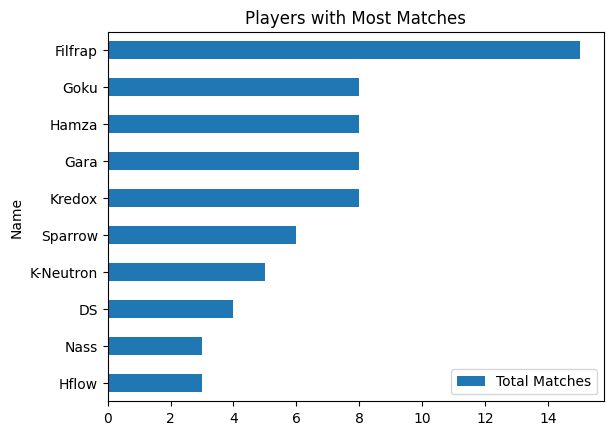

In [25]:
ax = final_df.sort_values(by='Total Matches') \
.tail(10).plot.barh(x="Name", y='Total Matches')
plt.title('Players with Most Matches')

In [17]:
most_matches

,Name,Rating,Total Matches
2,Filfrap,1525.960718,15
0,Goku,1579.221439,8
17,Kredox,1495.921515,8
1,Hamza,1536.210012,8
8,Gara,1500.555993,8
35,Sparrow,1477.315958,6
4,K-Neutron,1510.668838,5
6,DS,1508.381727,4
19,Nass,1492.372709,3
18,Matteo,1492.619963,3
